# The Devil lives in the details
> Resizing method matters...

Yesterday I was refactoring some code to put on our production code base. It is a simple image classifier trained with fastai. In our deployemtn evnirnment we are not including fastai as requirements and rely only on pure pytorch to process the data and make the inferece. (I am waiting to finally be able to import only the fastai vision part, without the NLP dependencies, this is coming soon, probably in fastai 2.3, at least it is in Jeremy's roadmap). So, I have to make the reading and preprocessing of images as close as possible as fastai `Transform` pipeline, to get accurate model outputs. 

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

In [3]:
def label_func(f): return f[0].isupper()

In [4]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

In [5]:
learn = cnn_learner(dls, resnet18)

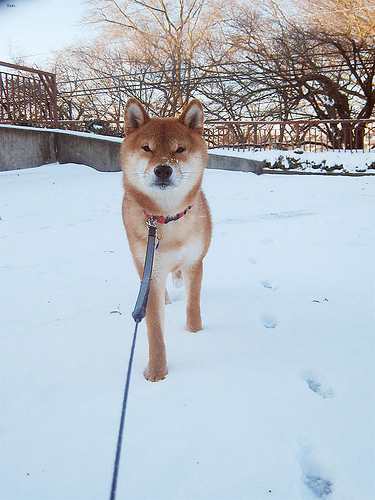

In [6]:
fname = files[1]
img = load_image(fname)
img

## PIL

In [7]:
pil_img = cast(PILImage.create(fname).resize((256,192)), PILImage)
tpil_img = ToTensor()(pil_img)
tpil_img.shape

torch.Size([3, 192, 256])

<AxesSubplot:>

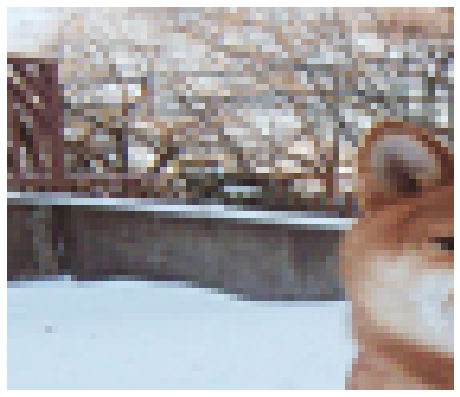

In [8]:
tpil_img[:,20:80, 30:100].show(figsize=(8,8))

In [9]:
learn.predict(tpil_img)

('True', tensor(1), tensor([0.2650, 0.7350]))

## OpenCV

In [47]:
import cv2

In [64]:
img_cv = cv2.imread(str(fname))
img_cv = cv2.resize(img_cv, 
                         (256,192), 
                         interpolation=cv2.INTER_LINEAR)

In [65]:
img_cv = img_cv.transpose((2,0,1))[::-1,:,:].copy()

In [66]:
timg_cv  = cast(img_cv, TensorImage)
timg_cv.shape

torch.Size([3, 192, 256])

<AxesSubplot:>

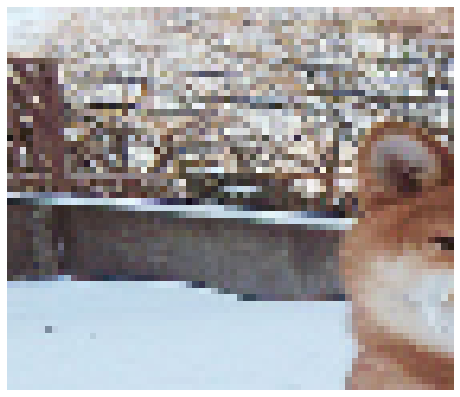

In [67]:
timg_cv[:,20:80, 30:100].show(figsize=(8,8))

In [68]:
learn.predict(timg_cv)

('True', tensor(1), tensor([0.3728, 0.6272]))

### with `INTER_AREA` flag

In [86]:
img_cv_area = cv2.imread(str(fname))
img_cv_area = cv2.resize(img_cv_area, 
                         (256,192), 
                         interpolation=cv2.INTER_AREA)

In [87]:
img_cv_area = img_cv_area.transpose((2,0,1))[::-1,:,:].copy()

In [88]:
timg_cv_area  = cast(img_cv_area, TensorImage)

<AxesSubplot:>

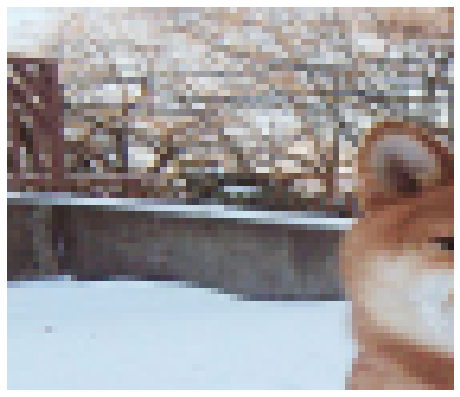

In [89]:
timg_cv_area[:,20:80, 30:100].show(figsize=(8,8))

In [90]:
learn.predict(timg_cv_area)

('True', tensor(1), tensor([0.3246, 0.6754]))

## Torchvision new Tensor API

In [53]:
import torchvision.transforms as T
from torchvision.io.image import read_image

In [54]:
timg = cast(read_image(str(fname)), TensorImage)

<AxesSubplot:>

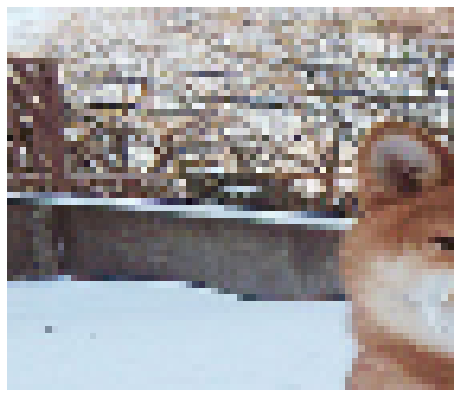

In [62]:
res = T.Resize((192,256), interpolation=2)
res(timg)[:,20:80, 30:100].show(figsize=(8,8))

In [63]:
learn.predict(timg)

('True', tensor(1), tensor([0.0650, 0.9350]))